# Praca inżynierska
Marcin Bobiński
nr albumu: 297225

In [2]:
import os
HOME_PATH = os.getcwd()
RESEARCH_PATH = os.path.join(HOME_PATH, "models/research")
DATASET_PATH = os.path.join(HOME_PATH, "Dataset")
PRETRAINED_MODELS_PATH = os.path.join(HOME_PATH, "pretrained_models")
DATA_PATH = os.path.join(HOME_PATH, "data")
TF_RECORD_PATH = os.path.join(DATA_PATH, "tf_record")
MY_MODEL = os.path.join(HOME_PATH, "my_model")

# Przygotowanie
## TensorFlow Object Detection Api
Pierwszym krokiem jest sklonowanie repezytorium
```
git clone https://github.com/tensorflow/models.git
```
</br>

Następnie należy zainstalować przy pomocy menadżera pakietów pip lub w wirtualnym środowisku Docker. W przypadku wyboru pierwszej opcji zalecana jest instalacja na nowym środowisku.

1. <strong>Pip </strong> </br>
Najpierw należy zainstalować Protobufa np. https://github.com/protocolbuffers/protobuf/releases </br>
Oraz dodać go do ścieżki.
Następnie, przy jego pomocy z poziomu katalogu models/research wywołać:
```
protoc object_detection/protos/*.proto --python_out=.
```
Z tego samego poziomu skopiować plik instalacyjny:
```
cp object_detection/packages/tf2/setup.py .
```
A następnie dokonać instalacji:
```
python -m pip install --use-feature=2020-resolver .
```

2. <strong> Docker </strong></br>
Przygotowanie środowiska:
```
docker build -f research/object_detection/dockerfiles/tf2/Dockerfile -t od .
```
Uruchomienie środowiska:
```
docker run -it od
```

Test przeprowadzonej instalacji można wykonać przy pomocy komendy:
```
python object_detection/builders/model_builder_tf2_test.py
```

In [ ]:
# Instalacja PIP
os.chdir(RESEARCH_PATH)
os.system("protoc object_detection/protos/*.proto --python_out=.")
os.system("cp object_detection/packages/tf2/setup.py .")
os.system("python -m pip install --use-feature=2020-resolver .")

In [ ]:
# Instalacja Docker
os.chdir(HOME_PATH)
os.system("docker build -f research/object_detection/dockerfiles/tf2/Dockerfile -t od .")
os.system("docker run -it od")

In [3]:
# Weryfikacja poprawności instalacji
os.chdir(RESEARCH_PATH)
result = os.system("python object_detection/builders/model_builder_tf2_test.py")
assert result==0, "Object detection api wasn't installed properly"

## Pobranie pretrenowanych modeli

In [2]:
# Stworzenie folderu dla pretrenowanych modeli
os.chdir(HOME_PATH)
PRETRAINED_MODELS_PATH = os.path.join(HOME_PATH, "pretrained_models")
if not os.path.exists(PRETRAINED_MODELS_PATH):
    os.makedirs(PRETRAINED_MODELS_PATH)

### Mask Rcnn model

In [17]:
import tensorflow as tf
import shutil

name = "mask_rcnn"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_name =  "mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)

MASK_RCNN_PATH = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))

### SSD mobilenet 640 v1

In [3]:
import tensorflow as tf
import shutil

name = "ssd_mobilenet_v1_640"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_name =  "ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)

_ = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))

### SSD mobilenet 640 v2

In [1]:
import tensorflow as tf
import shutil

name = "ssd_mobilenet_v2_640"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_name =  "ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)

SSD640_PATH = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))

90464256/90453990 [==============================] - 2s 0us/step


NameError: name 'os' is not defined

### SSD mobilenet320 v2

In [6]:
import tensorflow as tf
import shutil

name = "ssd_mobilenet_v2_320"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_name =  "ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)

SSD320_PATH = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))

20529152/20515344 [==============================] - 2s 0us/step


### SSD Resnet101 640

In [4]:
import tensorflow as tf
import shutil

name = "ssd640resnet"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_name =  "ssd_resnet101_v1_fpn_640x640_coco17_tpu-8"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)

SSD640RESNET_PATH = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))


386539520/386527459 [==============================] - 25s 0us/step


### Deep_mac

In [4]:
import tensorflow as tf
import shutil

name = "deepmac"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20210329/'
model_name =  "deepmac_1024x1024_coco17"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)

DEEPMAC_PATH = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))

1792917504/1792904062 [==============================] - 88s 0us/step


### Centernet hg104 512x512

In [5]:
import tensorflow as tf
import shutil

name = "centernet"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200713/'
model_name =  "centernet_hg104_512x512_coco17_tpu-8"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)

CENTERNET_PATH = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))

1426112512/1426099846 [==============================] - 63s 0us/step


### CenterNet MobileNetV2 FPN 512x512

In [5]:
import tensorflow as tf
import shutil

name = "centernet_mobile"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20210210/'
model_name =  "centernet_mobilenetv2fpn_512x512_coco17_od"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)

model_dir = str(model_dir).replace(model_name, "centernet_mobilenetv2_fpn_od")

CENTERNET_MOBILE_PATH = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))

### EfficientDet D1 640x640

In [8]:
import tensorflow as tf
import shutil

name = "efficientdet_d1"
base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
model_name =  "efficientdet_d1_coco17_tpu-32"
model_file = model_name + '.tar.gz'

model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True
)
_ = shutil.copytree(model_dir, os.path.join(PRETRAINED_MODELS_PATH, name))

51855360/51839363 [==============================] - 2s 0us/step


## Pobranie datasetu

### LabelMe
Zdjęcia drzew pobrane ze strony: http://labelme.csail.mit.edu/Release3.0/
</br>
Linki do pobrania datasetu:
- train: http://groups.csail.mit.edu/vision/LabelMe/Benchmarks/spain/training.tar.gz
- test: http://groups.csail.mit.edu/vision/LabelMe/Benchmarks/spain/test.tar.gz

In [4]:
import tensorflow as tf
import shutil

# Stworzenie folderu dla pobranego datasetu
os.chdir(HOME_PATH)
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)

name = "labelme"

train_url = "http://groups.csail.mit.edu/vision/LabelMe/Benchmarks/spain/training.tar.gz"
train_dir = tf.keras.utils.get_file(
    fname="train",
    origin=train_url,
    untar=True
)
_ = shutil.copytree(train_dir, os.path.join(DATASET_PATH, name, "train"))

test_url = "http://groups.csail.mit.edu/vision/LabelMe/Benchmarks/spain/test.tar.gz"
test_dir = tf.keras.utils.get_file(
    fname="test",
    origin=test_url,
    untar=True
)
_ = shutil.copytree(test_dir, os.path.join(DATASET_PATH, name, "test"))

1978990592/1978974639 [==============================] - 175s 0us/step


### Open Image

In [2]:
# Stworzenie folderu dla pobranego datasetu
name = "open-images"
os.chdir(HOME_PATH)
if not os.path.exists(DATASET_PATH):
    os.makedirs(DATASET_PATH)
if not os.path.exists(os.path.join(DATASET_PATH, name)):
    os.makedirs(os.path.join(DATASET_PATH, name))

In [3]:
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "open-images-v6",
    label_types=["detections"],
    classes=["Tree"],
    split="train",
    dataset_dir=os.path.join(DATASET_PATH, name),
    max_samples = int(16000),
    seed=1
)

dataset = foz.load_zoo_dataset(
    "open-images-v6",
    label_types=["detections"],
    classes=["Tree"],
    split="validation",
    dataset_dir=os.path.join(DATASET_PATH, name),
    max_samples = int(4000),
    seed=2
)

 100% |██████|    4.8Gb/4.8Gb [29.7s elapsed, 0s remaining, 301.8Mb/s]      
 100% |███████████████| 16000/16000 [11.6m elapsed, 0s remaining, 24.0 files/s]      
Dataset info written to 'D:\DEV\GeoTree\TreeDetection\Dataset\open-images\info.json'
Loading 'open-images-v6' split 'train'
 100% |█████████████| 16000/16000 [2.3m elapsed, 0s remaining, 127.6 samples/s]      
Dataset 'open-images-v6-train-16000' created
Only found 3611 (<4000) samples matching your requirements
 100% |█████████████████| 3611/3611 [2.7m elapsed, 0s remaining, 29.0 files/s]      
Dataset info written to 'D:\DEV\GeoTree\TreeDetection\Dataset\open-images\info.json'
Loading 'open-images-v6' split 'validation'
 100% |███████████████| 3611/3611 [37.0s elapsed, 0s remaining, 98.0 samples/s]       
Dataset 'open-images-v6-validation-4000' created


In [11]:
import fiftyone as fo
print(fo.list_datasets())

['open-images-v6-train-2400', 'open-images-v6-train-8000', 'open-images-v6-validation-2000', 'open-images-v6-validation-600']


In [ ]:
import fiftyone as fo

ds = fo.load_dataset("open-images-v6-train-validation-100")
fo.launch_app(ds)

## Przygotowywanie zdjęć
### LabelMe

In [2]:
import os
import shutil
# copy data only from test and split it
_ = shutil.copytree(os.path.join(DATASET_PATH,"test"), os.path.join(DATA_PATH, "train"))

In [3]:
from utils import prepare_data_utils as pdu

pdu.filterAndPrepareDataFromLabelMe(DATA_PATH, "train", ["tree"], ["trees"])

In [4]:
import os
import shutil
from utils import prepare_data_utils as pdu

pdu.flatten(os.path.join(DATA_PATH, "train"))

shutil.rmtree(os.path.join(DATA_PATH, "train/Images" ))
shutil.rmtree(os.path.join(DATA_PATH, "train/Annotations" ))

In [5]:
import os
import shutil

# move 20% of train images to test
if not os.path.exists(os.path.join(DATA_PATH, "test")):
    os.makedirs(os.path.join(DATA_PATH, "test"))

images = os.listdir(os.path.join(DATA_PATH, "train"))
images = list(filter(lambda image: str(image).endswith(".jpg"), images))
images = images[0:len(images)//5]

for image in images:
    shutil.move(
        os.path.join(DATA_PATH, f"train\\{image}").replace(".jpg", ".xml"),
        os.path.join(DATA_PATH, f"test\\{image}").replace(".jpg", ".xml")
    )
    shutil.move(os.path.join(DATA_PATH, f"train\\{image}"), os.path.join(DATA_PATH, f"test\\{image}"))

### Open image

In [4]:
from utils import oidv6_to_voc as otv

OID_PATH = os.path.join(DATASET_PATH, "open-images")

for split in ["train","validation"]:
    otv.convert(
        [os.path.join(OID_PATH, split, "labels", "detections.csv")],
        os.path.join(OID_PATH, split, "metadata", "classes.csv"),
        os.path.join(OID_PATH, split, "data"),
        os.path.join(OID_PATH, split, "data")
    )

Getting image ids...
Reading annotation CSV...
Generating VOC XMLs...
Getting image ids...
Reading annotation CSV...
Generating VOC XMLs...


In [5]:
from utils import prepare_data_utils as pdu

for split in ["train","validation"]:
    pdu.filterAndPrepareDataFromOI(
        os.path.join(DATASET_PATH, "open-images", split, "data"),
        ["Tree"],
        "tree"
    )

# Uczenie modelu
## Przygotowanie plików tf record

In [6]:
import os

if not os.path.exists(TF_RECORD_PATH):
    os.makedirs(TF_RECORD_PATH)

### Label me

In [15]:
from utils.tree_tf_record import create_tf_record_from_xml

create_tf_record_from_xml(os.path.join(DATA_PATH, "train"), os.path.join(TF_RECORD_PATH, "train"), 25, False)
create_tf_record_from_xml(os.path.join(DATA_PATH, "test"), os.path.join(TF_RECORD_PATH, "test"), 10, False)

Finished
Total annotations skipped: 46
Finished
Total annotations skipped: 0


### Open images

In [7]:
from utils.tree_tf_record import create_tf_record_from_xml

create_tf_record_from_xml(os.path.join(DATASET_PATH, "open-images", "train", "data"), os.path.join(TF_RECORD_PATH, "train"), 25, False)
create_tf_record_from_xml(os.path.join(DATASET_PATH, "open-images", "validation", "data"), os.path.join(TF_RECORD_PATH, "test"), 10, False)

Finished
Total annotations skipped: 0
Finished
Total annotations skipped: 0


Label Map

In [8]:
with open(os.path.join(DATA_PATH, "annotations.pbtxt"), 'w') as file:
    file.write("item { \n\tid: 1\n\tname: \'tree\'\n}")

Config

In [3]:
import os
import shutil

os.chdir(HOME_PATH)
if not os.path.exists(MY_MODEL):
    os.makedirs(MY_MODEL)

shutil.copy(
    os.path.join(PRETRAINED_MODELS_PATH,"ssd640","pipeline.config"),
    MY_MODEL
)

'D:\\DEV\\GeoTree\\TreeDetection\\my_model\\pipeline.config'

Uczenie

In [2]:
training = f"python object_detection/model_main_tf2.py \
--pipeline_config_path={os.path.join(MY_MODEL,'pipeline.config')} \
--model_dir={os.path.join(MY_MODEL,'checkpoints')} \
--alsologtostderr"
print(training)

python object_detection/model_main_tf2.py --pipeline_config_path=D:\DEV\GeoTree\TreeDetection\my_model\pipeline.config --model_dir=D:\DEV\GeoTree\TreeDetection\my_model\checkpoints --alsologtostderr


In [21]:
tensorboard = f"tensorboard --logdir={os.path.join(MY_MODEL,'checkpoints')}"
print(tensorboard)

tensorboard --logdir=D:\DEV\GeoTree\TreeDetection\my_model\checkpoints


Export the inference graph

In [3]:
os.chdir(RESEARCH_PATH)

os.system(f"python object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path {os.path.join(MY_MODEL,'pipeline.config')} \
    --trained_checkpoint_dir {os.path.join(MY_MODEL,'checkpoints')} \
    --output_directory {os.path.join(MY_MODEL, 'inference_graph')}")

1

Export TF Lite graph

In [2]:
os.chdir(RESEARCH_PATH)

os.system(f"python object_detection/export_tflite_graph_tf2.py \
    --pipeline_config_path {os.path.join(MY_MODEL,'pipeline.config')} \
    --trained_checkpoint_dir {os.path.join(MY_MODEL,'checkpoints')} \
    --output_directory {os.path.join(MY_MODEL, 'inference_tflite_graph')}")

0

In [3]:
import tensorflow as tf

os.chdir(os.path.join(MY_MODEL, 'inference_tflite_graph'))

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join(MY_MODEL, 'inference_tflite_graph', 'saved_model')) # path to the SavedModel directory
converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Mask-RCNN

In [8]:
import tensorflow as tf
model = tf.saved_model.load(os.path.join(MY_MODEL,"inference_graph","saved_model"))

os.chdir(os.path.join(MY_MODEL, 'inference_tflite_graph'))

keras_model = model.keras_model
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

converter.optimizations = [ tf.lite.Optimize.DEFAULT ]

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

AttributeError: '_UserObject' object has no attribute 'keras_model'

In [4]:
import tensorflow as tf

os.chdir(os.path.join(MY_MODEL, 'inference_tflite_graph'))

converter = tf.lite.TFLiteConverter.from_saved_model(os.path.join(MY_MODEL,"inference_graph","saved_model"))
converter.allow_custom_ops = True
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

# converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
converter.optimizations = [ tf.lite.Optimize.OPTIMIZE_FOR_SIZE ]
# converter.optimizations = [ tf.lite.Optimize.EXPERIMENTAL_SPARSITY ]

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Testing

In [4]:
import tensorflow as tf
model = tf.saved_model.load(os.path.join(MY_MODEL, "inference_tflite_graph","saved_model"))

In [5]:
model.signatures['serving_default'].output_shapes

{'output_3': TensorShape([]),
 'output_1': TensorShape([]),
 'output_2': TensorShape([]),
 'output_0': TensorShape([])}

In [6]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path=os.path.join(MY_MODEL, "inference_tflite_graph","model.tflite"))
interpreter.allocate_tensors()

# Print input shape and type
print(interpreter.get_input_details()[0]['shape'])
print(interpreter.get_input_details()[0]['dtype'])

# Print output shape and type
print("-"*20)
print(interpreter.get_output_details()[0]['shape'])
print(interpreter.get_output_details()[0]['dtype'])
print("-"*20)
print(interpreter.get_output_details()[1]['shape'])
print(interpreter.get_output_details()[1]['dtype'])
print("-"*20)
print(interpreter.get_output_details()[2]['shape'])
print(interpreter.get_output_details()[2]['dtype'])
print("-"*20)
print(interpreter.get_output_details()[3]['shape'])
print(interpreter.get_output_details()[3]['dtype'])

[  1 640 640   3]
<class 'numpy.float32'>
--------------------
[ 1 10]
<class 'numpy.float32'>
--------------------
[ 1 10  4]
<class 'numpy.float32'>
--------------------
[1]
<class 'numpy.float32'>
--------------------
[ 1 10]
<class 'numpy.float32'>


In [2]:
import numpy as np
import os
import tensorflow as tf

from PIL import Image
from IPython.display import display

from models.research.object_detection.utils import ops as utils_ops
from models.research.object_detection.utils import label_map_util
from models.research.object_detection.utils import visualization_utils as vis_util


utils_ops.tf = tf.compat.v1
tf.gfile = tf.io.gfile

model = tf.saved_model.load(os.path.join(MY_MODEL,"inference_graph","saved_model"))
category_index = label_map_util.create_category_index_from_labelmap(os.path.join(DATA_PATH, "annotations.pbtxt"), use_display_name=True)

def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    need_detection_key = ['detection_classes','detection_boxes','detection_masks','detection_scores']
    output_dict = {key: output_dict[key][0, :num_detections].numpy()
               for key in need_detection_key}
    output_dict['num_detections'] = num_detections
    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            tf.convert_to_tensor(output_dict['detection_masks']), output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    return output_dict

def show_inference(model, image_path):
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=4)

    display(Image.fromarray(image_np))

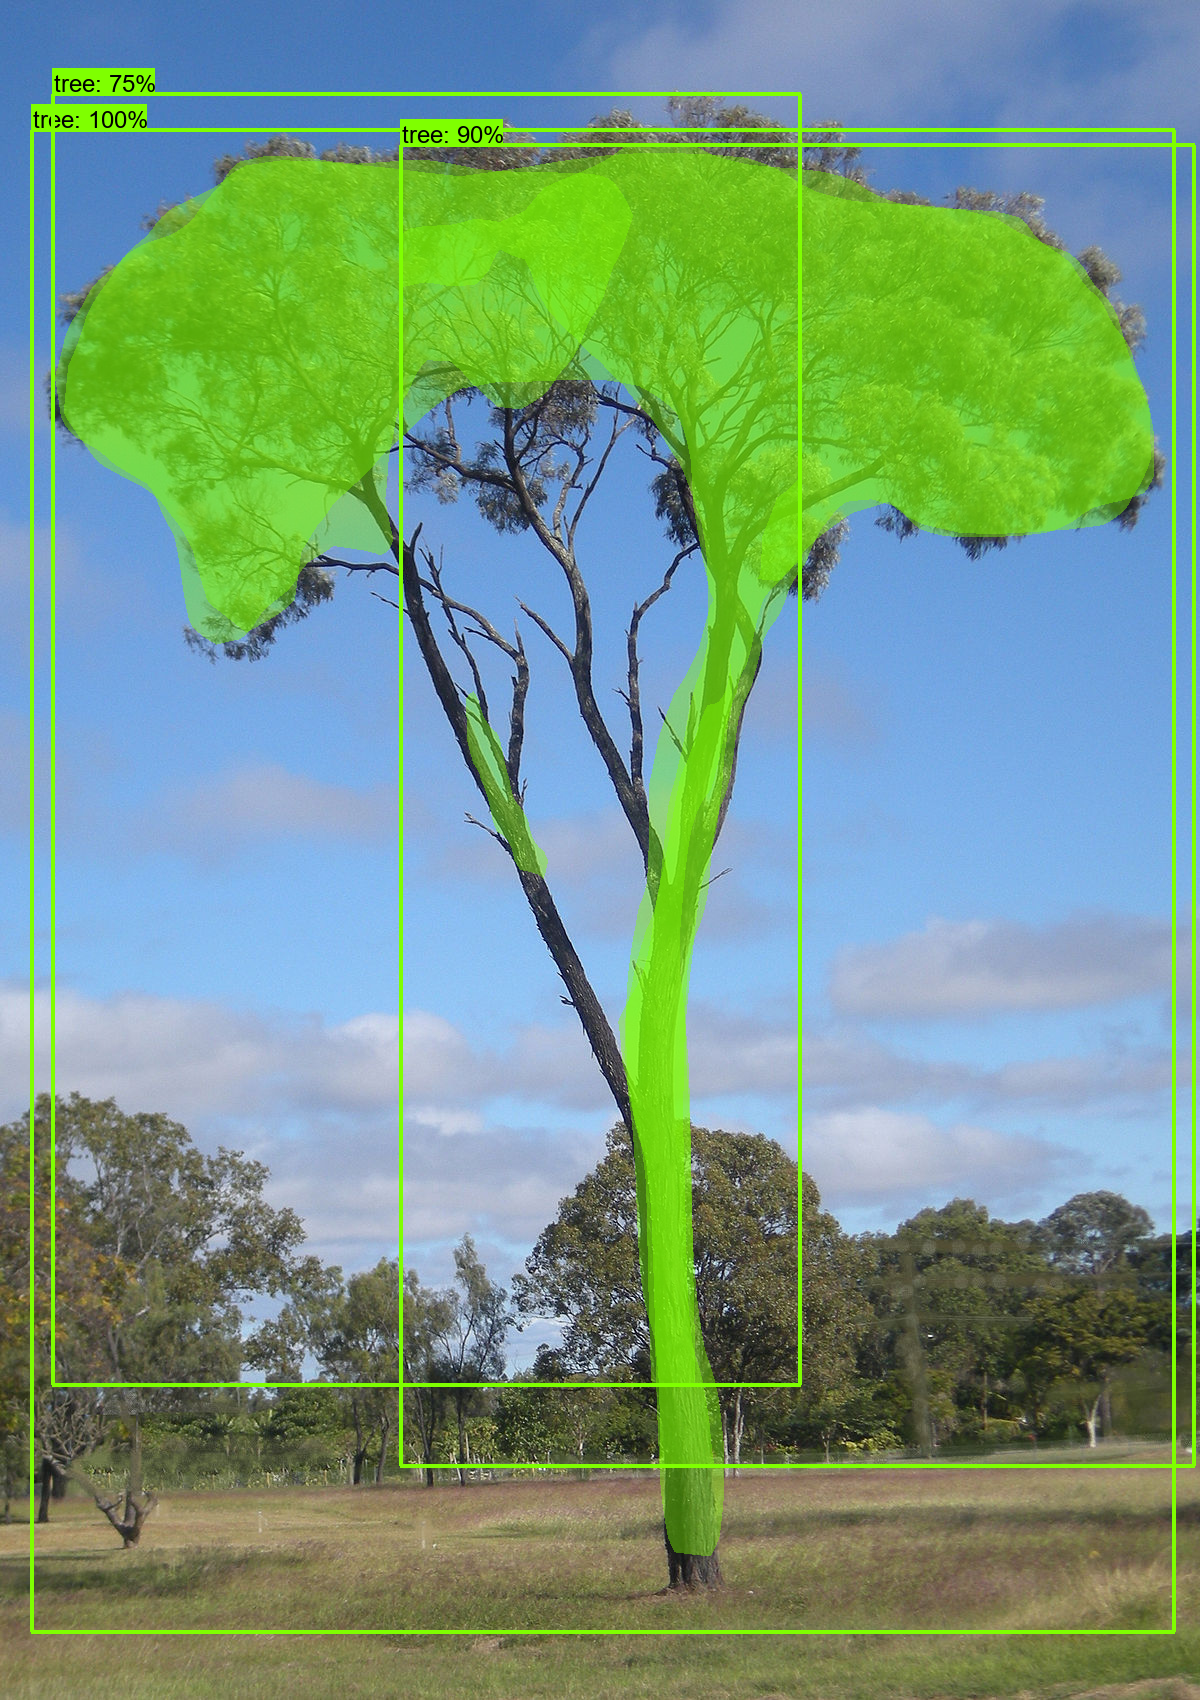

In [3]:

images = list(filter(lambda x: str(x).endswith(".jpg"),os.listdir(DATA_PATH)))
for image in images:
    show_inference(model, os.path.join(DATA_PATH, image))